For this homework, make sure that you format your notbook nicely and cite all sources in the appropriate sections. Programmatically generate or embed any figures or graphs that you need.

Names: __Lucas Calero Forero, Rebecca McBrayer__

Step 1: Word2Vec paper questions
---------------------------
1. Describe how a CBOW word embedding is generated.

A feedforward Neural Net without a hidden layer with a shared projection layer is used to classify the current word on every iteration based on its context (previous and future words). The output is a word embedding of size V.

2. What is a CBOW word embedding and how is it different from a skip-gram word embedding?

The biggest difference between skip-gram and CBOW is the fact that skip-gram uses the current word as the input into the classifier and predicts words within a range R of the word 1 < R < C where C is the maxiumum distance. This technique allows for weighted classification depending on the distance from w(i) and the current word.  

3. What is the task that the authors use to evaluate the generated word embeddings?

The authors use the Semantic-Syntactic Word Relationship test set to evaluate their generated word embeddings, a test set developed by them for this paper and for future research.

4. What are PCA and t-SNE? Why are these important to the task of training and interpreting word embeddings?

PCA and t-SNE are methods of dimensionality reduction, projecting high-dimensional word embeddings into lower dimensional space. This is important foor training and interpreting word embeddings since embeddings can become extremely high dimensional, and projecting them into a lower space will both speed up training time and make it easier for humans to visualize and therefore interpret.

Step 2: Train your own word embeddings
--------------------------------

The Spooky Authors dataset is an old competition dataset from Kaggle. It has example sentences from famous works of writing from three different authors. For this assignment, each data point is a single sentence written by one of the three gothic authors.

Describe what data set you have chosen to compare and contrast with the Spooky Authors Dataset. Make sure to describe where it comes from and its general properties.

We chose the text of Les Miserables as our second dataset. This comes from Project Gutenburg and has over 500,000 words in its translated form.

In [1]:
# import your libraries here
import string
import urllib.request

from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize
import numpy as np
import pandas as pd
import tensorflow as tf

# Importing utility functions from Keras
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Embedding


### a) Train embeddings on GIVEN dataset

In [2]:
# Read the file 'spooky-author-identification/train.csv' 
spooky = pd.read_csv('train.csv')

In [3]:
# code to train your word embeddings
spooky_text = list(spooky['text'])

# Remove punctuation
exclude = set(string.punctuation)
spooky_nopun = []
for st in spooky_text:
  st = ''.join(ch for ch in st if ch not in exclude)
  spooky_nopun.append(st)

# Add start and ending tokens, and make all words lowercase
spooky_text = ["<s> {} </s>".format(sentence.lower()) for sentence in spooky_nopun]
spooky_data = [sentence.split() for sentence in spooky_text]

In [96]:
# The dimension of word embedding. 
# This variable will be used throughout the program
# you may vary this as you desire
EMBEDDINGS_SIZE = 200

# Train the Word2Vec model from Gensim. 
# Below are the hyperparameters that are most relevant. 
# But feel free to explore other 
# options too:
# sg = 1
# window = 5
# size = EMBEDDING_SIZE
# min_count = 1

spooky_model = Word2Vec(sentences=spooky_data, size=EMBEDDINGS_SIZE, window=5, min_count=1, workers=4)
spooky_model.save("word2vec.model")

In [97]:
# if you save your Word2Vec as the variable model, this will 
# print out the vocabulary size
print('Vocab size {}'.format(len(spooky_model.wv.vocab)))

Vocab size 25413


In [99]:
# You can save file in txt format, then load later if you wish.
spooky_model.wv.save_word2vec_format('embeddings.txt', binary=False)

### b) Train embedding on YOUR dataset

In [7]:
# Pull the data from Project Gutenburg
with urllib.request.urlopen("http://www.gutenberg.org/files/135/135-0.txt") as f:
    content = f.read()

text = content.decode('utf-8-sig')

# Remove parts of the text that aren't the book itself, plus extraneous whitespace
text = text[text.find("So long as there shall exist"):text.find("Publisher of the Italian translation ")]
text = ''.join(ch for ch in text if ch not in ['\n','\r'])

# Tokenize
sentences = sent_tokenize(text)

In [8]:
# Remove punctuation
exclude = set(string.punctuation)
text_nopun = []
for st in sentences:
    st = ''.join(ch for ch in st if ch not in exclude)
    text_nopun.append(st)

# Add start and ending tokens, and make all words lowercase
text = ["<s> {} </s>".format(sentence.lower()) for sentence in text_nopun]
lesmis_data = [sentence.split() for sentence in text]
lesmis_data = list(filter(lambda a: len(a)>2, lesmis_data))  # Remove blank sentences

In [9]:
EMBEDDINGS_SIZE = 200

# Train the Word2Vec model from Gensim. 
# Below are the hyperparameters that are most relevant. 
# But feel free to explore other 
# options too:
# sg = 1
# window = 5
# size = EMBEDDING_SIZE
# min_count = 1

lesmis_model = Word2Vec(sentences=lesmis_data, size=EMBEDDINGS_SIZE, window=5, min_count=1, workers=4)
lesmis_model.save("lesmis_word2vec.model")

In [10]:
lesmis_model.wv.save_word2vec_format('lesmis_embeddings.txt', binary=False)
print('Vocab size {}'.format(len(lesmis_model.wv.vocab)))

Vocab size 63355


What text-normalization and pre-processing did you do and why? __We chose to do only very minimal text preprocessing, to keep our implementation simple. We removed punctuation and made all words lowercase, since those have no impact on the meaning of words (and therefore how they should be represented by an embedding. We added start and end tokens to make learning easier, but otherwise left the sentences alone. We did not lemmatize, as the different forms of words will have different meanings and therefore we decided to let them be embedded differently.__

Step 3: Evaluate the differences between the word embeddings
----------------------------

(make sure to include graphs, figures, and paragraphs with full sentences)

In [116]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

X_spooky = TSNE(n_components=2).fit_transform(spooky_model.wv['fall'].reshape(-1, 1))
X_lesmis = TSNE(n_components=2).fit_transform(lesmis_model.wv['fall'].reshape(-1, 1))

TypeError: plot() missing 1 required positional argument: 'ys'

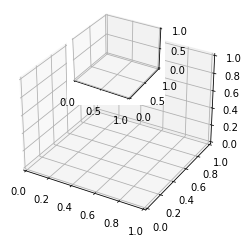

In [110]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(X_spooky)
ax.plot(X_lesmis)
plt.show()

Cite your sources:
-------------

Step 4: Feedforward Neural Language Model
--------------------------

### a) First, encode  your text into integers

In [11]:
NGRAM = 3 # The size of the ngram language model you want to train

flat_data = [word for sent in spooky_data for word in sent]
spooky_vocab = list(set(flat_data))

# Initializing a Tokenizer
spooky_tokenizer = Tokenizer()
spooky_tokenizer.fit_on_texts(flat_data)

indexed_spooky_data = tokenizer.texts_to_sequences(spooky_data)
indexed_spooky_vocab = tokenizer.texts_to_sequences(spooky_vocab)

spooky_word_to_index = {word:index[0] for word, index in zip(list(spooky_vocab), indexed_spooky_vocab)}
spooky_index_to_word = {index[0]:word for word, index in zip(list(spooky_vocab), indexed_spooky_vocab)}

In [ ]:
flat_data = [word for sent in lesmis_data for word in sent]
lesmis_vocab = list(set(flat_data))

# Initializing a Tokenizer
lesmis_tokenizer = Tokenizer()
lesmis_tokenizer.fit_on_texts(flat_data)

indexed_lesmis_data = tokenizer.texts_to_sequences(lesmis_data)
indexed_lesmis_vocab = tokenizer.texts_to_sequences(lesmis_vocab)

lesmis_word_to_index = {word:index[0] for word, index in zip(list(lesmis_vocab), indexed_lesmis_vocab)}
lesmis_index_to_word = {index[0]:word for word, index in zip(list(lesmis_vocab), indexed_lesmis_vocab)}

### b) Next, prepare your sequences from text

#### Fixed ngram based sequences (Used for Feedforward)

The training samples will be structured in the following format. 
Depending on which ngram model we choose, there will be (n-1) tokens 
in the input sequence (X) and we will need to predict the nth token (Y)

            X,						  y
    this,    process               however
    process, however               afforded
    however, afforded	           me

In [12]:
def generate_ngram_training_samples(content: list) -> list:
    '''
    Takes the encoded data (list of lists) and 
    generates the training samples out of it.
    Parameters:
    up to you, we've put in what we used
    but you can add/remove as needed
    return: 
    list of lists in the format [[x1, x2, ... , x(n-1), y], ...]
    '''
    ngrams = []
    for sent in content:
        for i in range(NGRAM-1, len(sent)):
            ngram = [sent[j] for j in range(i-(NGRAM-1), i+1)]
            ngrams.append(ngram)
    return ngrams

### c) Then, split the sequences into X and y and create a Data Generator

In [13]:
def read_embeddings(path: string) -> (dict,dict):
    '''Loads and parses embeddings trained in earlier.
    Parameters and return values are up to you.
    '''
    # you may find generating the following two dicts useful:
    # word to embedding : {'the':1, ...}
    # index to embedding : {1:'the', ...} (inverse of word_2_embedding)
    
    model = Word2Vec.load(path)
    word_to_embedding = {}
    index_to_embedding = {}
    for word in model.wv.vocab.keys():
        index = word_to_index[word]
        embedding = model.wv[word]
        word_to_embedding[word] = embedding
        index_to_embedding[index] = embedding
    return word_to_embedding, index_to_embedding

### Create the x & y lists

In [14]:
spooky_ngrams = generate_ngram_training_samples(indexed_spooky_data)
encoded_X = []
encoded_Y = []
for ngram in spooky_ngrams:
    encoded_X.append(ngram[:NGRAM-1])
    encoded_Y.append(ngram[-1])

spooky_word_to_embedding, spooky_index_to_embedding = read_embeddings("word2vec.model")

In [15]:
def data_generator(X: list, Y: list, num_sequences_per_batch: int) -> (list,list):
    '''
    Returns data generator to be used by feed_forward
    https://wiki.python.org/moin/Generators
    https://realpython.com/introduction-to-python-generators/
    
    Yields batches of embeddings and labels to go with them.
    Use one hot vectors to encode the labels 
    (see the to_categorical function)
    
    '''
    num_sequences = 0
    
    while True:
        next_X = X[num_sequences: num_sequences+num_sequences_per_batch]
        next_X_vec = []
        for X_sent in next_X:
            X_sent_next = []
            for ii in X_sent:
                X_sent_next.extend(spooky_index_to_embedding[ii])
            next_X_vec.append(X_sent_next)
        
        next_Y = Y[num_sequences: num_sequences+num_sequences_per_batch]
        next_Y_cat = [tf.keras.utils.to_categorical(vec, num_classes=len(spooky_vocab)) for vec in next_Y]
        next_Y_tensor = np.array([tf.keras.backend.constant(cat) for cat in next_Y_cat])
        
        yield tf.keras.backend.constant(next_X_vec),next_Y_tensor
        num_sequences += num_sequences_per_batch

In [16]:
# Examples
# initialize data_generator
sequences = indexed_spooky_data
num_sequences_per_batch = 128 # this is the batch size
steps_per_epoch = len(sequences)//num_sequences_per_batch  # Number of batches per epoch
train_generator = data_generator(encoded_X, encoded_Y, num_sequences_per_batch)

sample=next(train_generator) # this is how you get data out of generators
sample[0].shape # (batch_size, (n-1)*EMBEDDING_SIZE)

TensorShape([128, 400])

### d) Train your models

In [89]:
# code to train a feedforward neural language model 
# on a set of given word embeddings
# make sure not to just copy + paste to train your two models

# Define the model architecture using Keras Sequential API

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(1052, input_dim=EMBEDDINGS_SIZE * (NGRAM-1)))
model.add(tf.keras.layers.Activation('tanh'))
model.add(tf.keras.layers.Dense(256, input_dim=EMBEDDINGS_SIZE * (NGRAM-1)))
model.add(tf.keras.layers.Activation('tanh'))
model.add(tf.keras.layers.Dense(25413))
model.add(tf.keras.layers.Activation('softmax'))
model.compile(optimizer='sgd', loss='binary_crossentropy')
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 1052)              421852    
_________________________________________________________________
activation_31 (Activation)   (None, 1052)              0         
_________________________________________________________________
dense_32 (Dense)             (None, 256)               269568    
_________________________________________________________________
activation_32 (Activation)   (None, 256)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 25413)             6531141   
_________________________________________________________________
activation_33 (Activation)   (None, 25413)             0         
Total params: 7,222,561
Trainable params: 7,222,561
Non-trainable params: 0
___________________________________________

In [90]:
# Start training the model
model.fit(x=train_generator,
          steps_per_epoch=steps_per_epoch,
          epochs=1)

152/152 [==============================] - 48s 319ms/step - loss: 4.3813e-04


### e) Generate Sentences

In [91]:
word_to_embedding = spooky_word_to_embedding

In [133]:
# generate a sequence from the model
def generate_seq(model: Sequential,
                 tokenizer: Tokenizer, 
                 seed: list, 
                 n_words: int):
    '''
    Parameters:
        model: your neural network (trained)
        tokenizer: the keras preprocessing tokenizer
        seed: [w1, w2, w(n-1)]
        n_words: generate a sentence of length n_words
    Returns: string sentence
    '''
    # initialize prediction list
    prediction_list = seed
    
    # Build the sentence
    while len(prediction_list) < n_words:
    
        # get last (NGRAM-1) words of list
        sample = prediction_list[-(NGRAM-1):]
    
        # Convert to embeddings, reshape properly
        sample_embedded = [word_to_embedding[word] for word in sample]
        sample_embedded = np.array(sample_embedded).reshape(-1, (NGRAM-1)*EMBEDDINGS_SIZE)
    
        # generate new word from these
        probabilities = model.predict(sample_embedded)[0]
        print(np.array(probabilities).shape)
        predicted_word_index = np.random.choice(np.arange(len(probabilities)), 1, p=probabilities)
        # predicted_word_index = predictions.argmax()
    
        # convert new word index to word and add it to list
        predicted_word = index_to_word[predicted_word_index]
        prediction_list.append(predicted_word)
    
    return prediction_list

In [131]:
len(list(word_to_index.values()))

25413

In [132]:
generate_seq(model, tokenizer, ['<s>', 'the'], 20)

(1, 25413)


ValueError: 'p' must be 1-dimensional

### f) Compare your generated sentences

Sources Cited
----------------------------
